# Análise de Fadiga em Componentes Aeronáuticos

Este notebook apresenta uma análise dos dados estruturais de uma fuselagem aeronáutica, focando no comportamento de fadiga e avaliação preditiva com KNN e Árvore de Decisão.

In [3]:
!pip install -q pandas seaborn matplotlib scikit-learn

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


# Carregar a base de dados
df = pd.read_csv("aircraft_fatigue.csv")
df.head()

,EID,type,material,stress_landing,stress_taxi,stress_lateral,stress_vertical,stress_pressurization,life,log_life
0,1,skin,1,-0.160388,-0.148503,1.804565,1.24634,2.832018,58204.451435,4.764956
1,2,skin,2,11.403720,4.825349,11.831360,12.24992,9.349614,3.772988,0.576685
2,3,skin,2,11.490120,4.799707,10.220180,10.51033,8.728369,10.534143,1.022599
3,4,skin,2,11.796380,4.957905,10.902360,10.82325,7.964283,7.243898,0.859972
4,5,skin,2,10.877260,4.495966,10.187770,10.85074,8.749962,7.870671,0.896012


In [45]:
# Estatísticas básicas e tipos
print("Estatísticas descritivas:")
display(df.describe())
print("\nTipos de dados:")
display(df.dtypes)
print("\nValores únicos por coluna:")
display(df.nunique())

Estatísticas descritivas:


,EID,material,stress_landing,stress_taxi,stress_lateral,stress_vertical,stress_pressurization,life,log_life
count,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,2.163500e+04,21635.000000
mean,10818.000000,1.711902,2.748109,1.445649,5.297806,5.282558,4.636918,5.092113e+17,3.757733
std,6245.630873,0.870385,3.440907,1.947720,4.510504,4.528405,4.005871,5.035092e+19,3.118429
min,1.000000,1.000000,-8.509144,-5.918386,-11.586440,-11.740950,-11.012150,6.636866e-02,-1.178037
25%,5409.500000,1.000000,0.243823,-0.009556,1.815565,1.672957,1.551748,2.242214e+01,1.350677
50%,10818.000000,1.000000,1.880849,0.931252,4.965043,5.052733,4.111456,7.524306e+02,2.876466
75%,16226.500000,3.000000,5.238305,3.129730,8.323815,8.400724,7.467462,2.575979e+05,5.410942
max,21635.000000,3.000000,13.468960,9.852309,31.582030,31.589610,31.219330,6.076139e+21,21.783628



Tipos de dados:


EID                        int64
type                      object
material                   int64
stress_landing           float64
stress_taxi              float64
stress_lateral           float64
stress_vertical          float64
stress_pressurization    float64
life                     float64
log_life                 float64
dtype: object


Valores únicos por coluna:


EID                      21635
type                         2
material                     3
stress_landing           21615
stress_taxi              21592
stress_lateral           21616
stress_vertical          21611
stress_pressurization    21615
life                     21635
log_life                 21635
dtype: int64

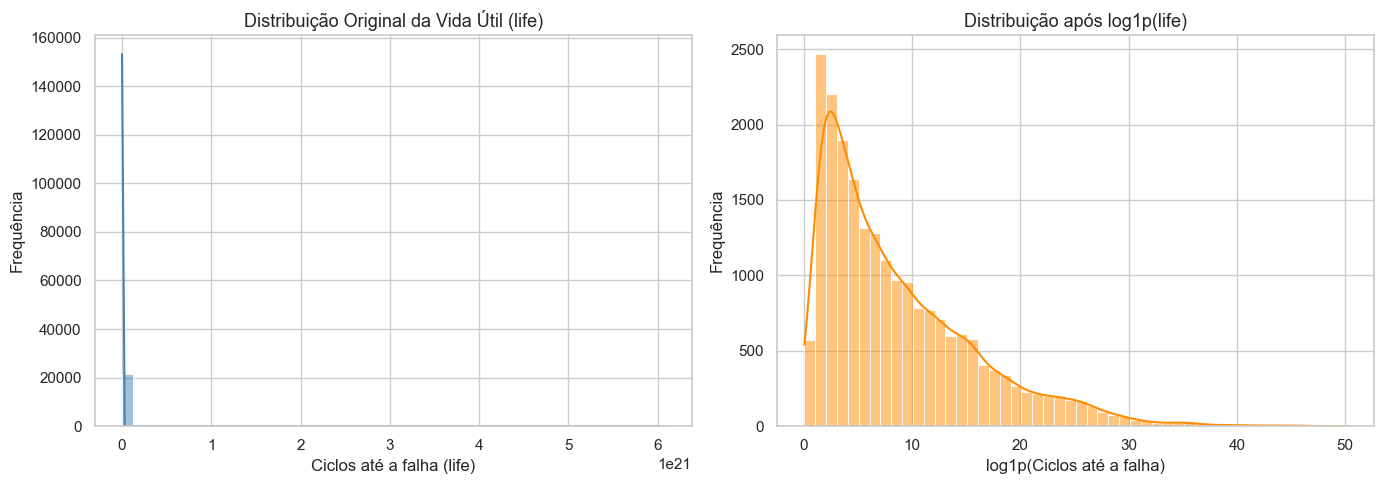

In [46]:
# Análise exploratória da variável alvo

plt.figure(figsize=(14, 5))
y=df['life']

# Distribuição original de 'life'
plt.subplot(1, 2, 1)
sns.histplot(y, bins=50, kde=True, color='steelblue')
plt.title("Distribuição Original da Vida Útil (life)", fontsize=13)
plt.xlabel("Ciclos até a falha (life)")
plt.ylabel("Frequência")
plt.grid(True)

# Distribuição com log1p
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(y), bins=50, kde=True, color='darkorange')
plt.title("Distribuição após log1p(life)", fontsize=13)
plt.xlabel("log1p(Ciclos até a falha)")
plt.ylabel("Frequência")
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Pré-processamento
df = df.drop(columns=['EID'], errors='ignore')

# Codificar 'type' como numérico
if df['type'].dtype == 'object':
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])

# One-hot encoding para 'material'
df = pd.get_dummies(df, columns=['material'], drop_first=True)

# Reescalonamento de colunas de stress
stress_cols = [col for col in df.columns if 'stress' in col]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[stress_cols] = scaler.fit_transform(df[stress_cols])

# Criar duas versões da base
df_no_trunc = df.copy()
df_trunc = df.copy()
df_trunc['life'] = df_trunc['life'].apply(lambda x: min(x, 1e5))

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Recarregar df original, caso necessário
df = pd.read_csv("aircraft_fatigue.csv")
df = df.drop(columns=['EID'], errors='ignore')

# Codificar 'type'
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # transforma 'skin', 'stringer' etc. em 0, 1

# One-hot encoding em 'material'
df = pd.get_dummies(df, columns=['material'], drop_first=True)

# Garantir que colunas 'material_2' e 'material_3' existam
for col in ['material_2', 'material_3']:
    if col not in df.columns:
        df[col] = 0

# Normalizar colunas de stress
stress_cols = [col for col in df.columns if 'stress' in col]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[stress_cols] = scaler.fit_transform(df[stress_cols])

# Agora sim pode criar df_no_trunc, df_trunc, df_log
df_no_trunc = df.copy()
df_trunc = df.copy()
df_trunc['life'] = df_trunc['life'].apply(lambda x: min(x, 1e5))
df_log = df.copy()
df_log['life'] = np.log1p(df_log['life'])



modelos = [
    ("KNN", KNeighborsRegressor()),
    ("Árvore de Decisão", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=10, random_state=42))
]


# Redefinir df_trunc e df_no_trunc com base no DataFrame original df
df_no_trunc = df.copy()
df_trunc = df.copy()
df_trunc['life'] = df_trunc['life'].apply(lambda x: min(x, 1e5))

# Repetir avaliação agora que os dados foram definidos corretamente
results_completo = []

for nome, modelo in modelos:
    results_completo.append(train_and_evaluate_full(df_no_trunc, modelo, nome, "Sem Truncamento"))
    results_completo.append(train_and_evaluate_full(df_trunc, modelo, nome, "Com Truncamento"))

# Base com log(life)
df_log = df.copy()
df_log['life'] = np.log1p(df_log['life'])

for nome, modelo in modelos:
    results_completo.append(train_and_evaluate_full(df_log, modelo, nome, "log(life)"))

# Gerar DataFrame final
results_df_completo = pd.DataFrame(results_completo)

results_df_completo


,Modelo,Truncado,MAE,RMSE,MSE,R²,R² (Holdout),R² CV Médio,R² CV Std
0,KNN,Sem Truncamento,1.195928e+18,7.832335e+19,6.134547e+39,0.280999,0.280999,0.784713,3.919925e-01
1,KNN,Com Truncamento,1.503537e+02,6.989463e+02,4.885260e+05,0.999752,0.999752,0.999147,7.084995e-04
2,Árvore de Decisão,Sem Truncamento,4.310391e+17,2.812461e+19,7.909934e+38,0.907291,0.907291,0.780831,3.902547e-01
3,Árvore de Decisão,Com Truncamento,7.135820e+00,3.693495e+01,1.364191e+03,0.999999,0.999999,0.999999,2.005978e-07
4,Random Forest,Sem Truncamento,8.910647e+17,5.850413e+19,3.422733e+39,0.598838,0.598838,0.775716,3.892928e-01
5,Random Forest,Com Truncamento,5.452598e+00,2.719649e+01,7.396493e+02,1.000000,1.000000,1.000000,1.809041e-07
6,KNN,log(life),3.193444e-02,7.480871e-02,5.596342e-03,0.999889,0.999889,0.999542,3.016210e-04
7,Árvore de Decisão,log(life),2.946384e-03,1.559406e-02,2.431749e-04,0.999995,0.999995,0.999847,2.921610e-04
8,Random Forest,log(life),2.935334e-03,3.623720e-02,1.313134e-03,0.999974,0.999974,0.999867,2.605155e-04


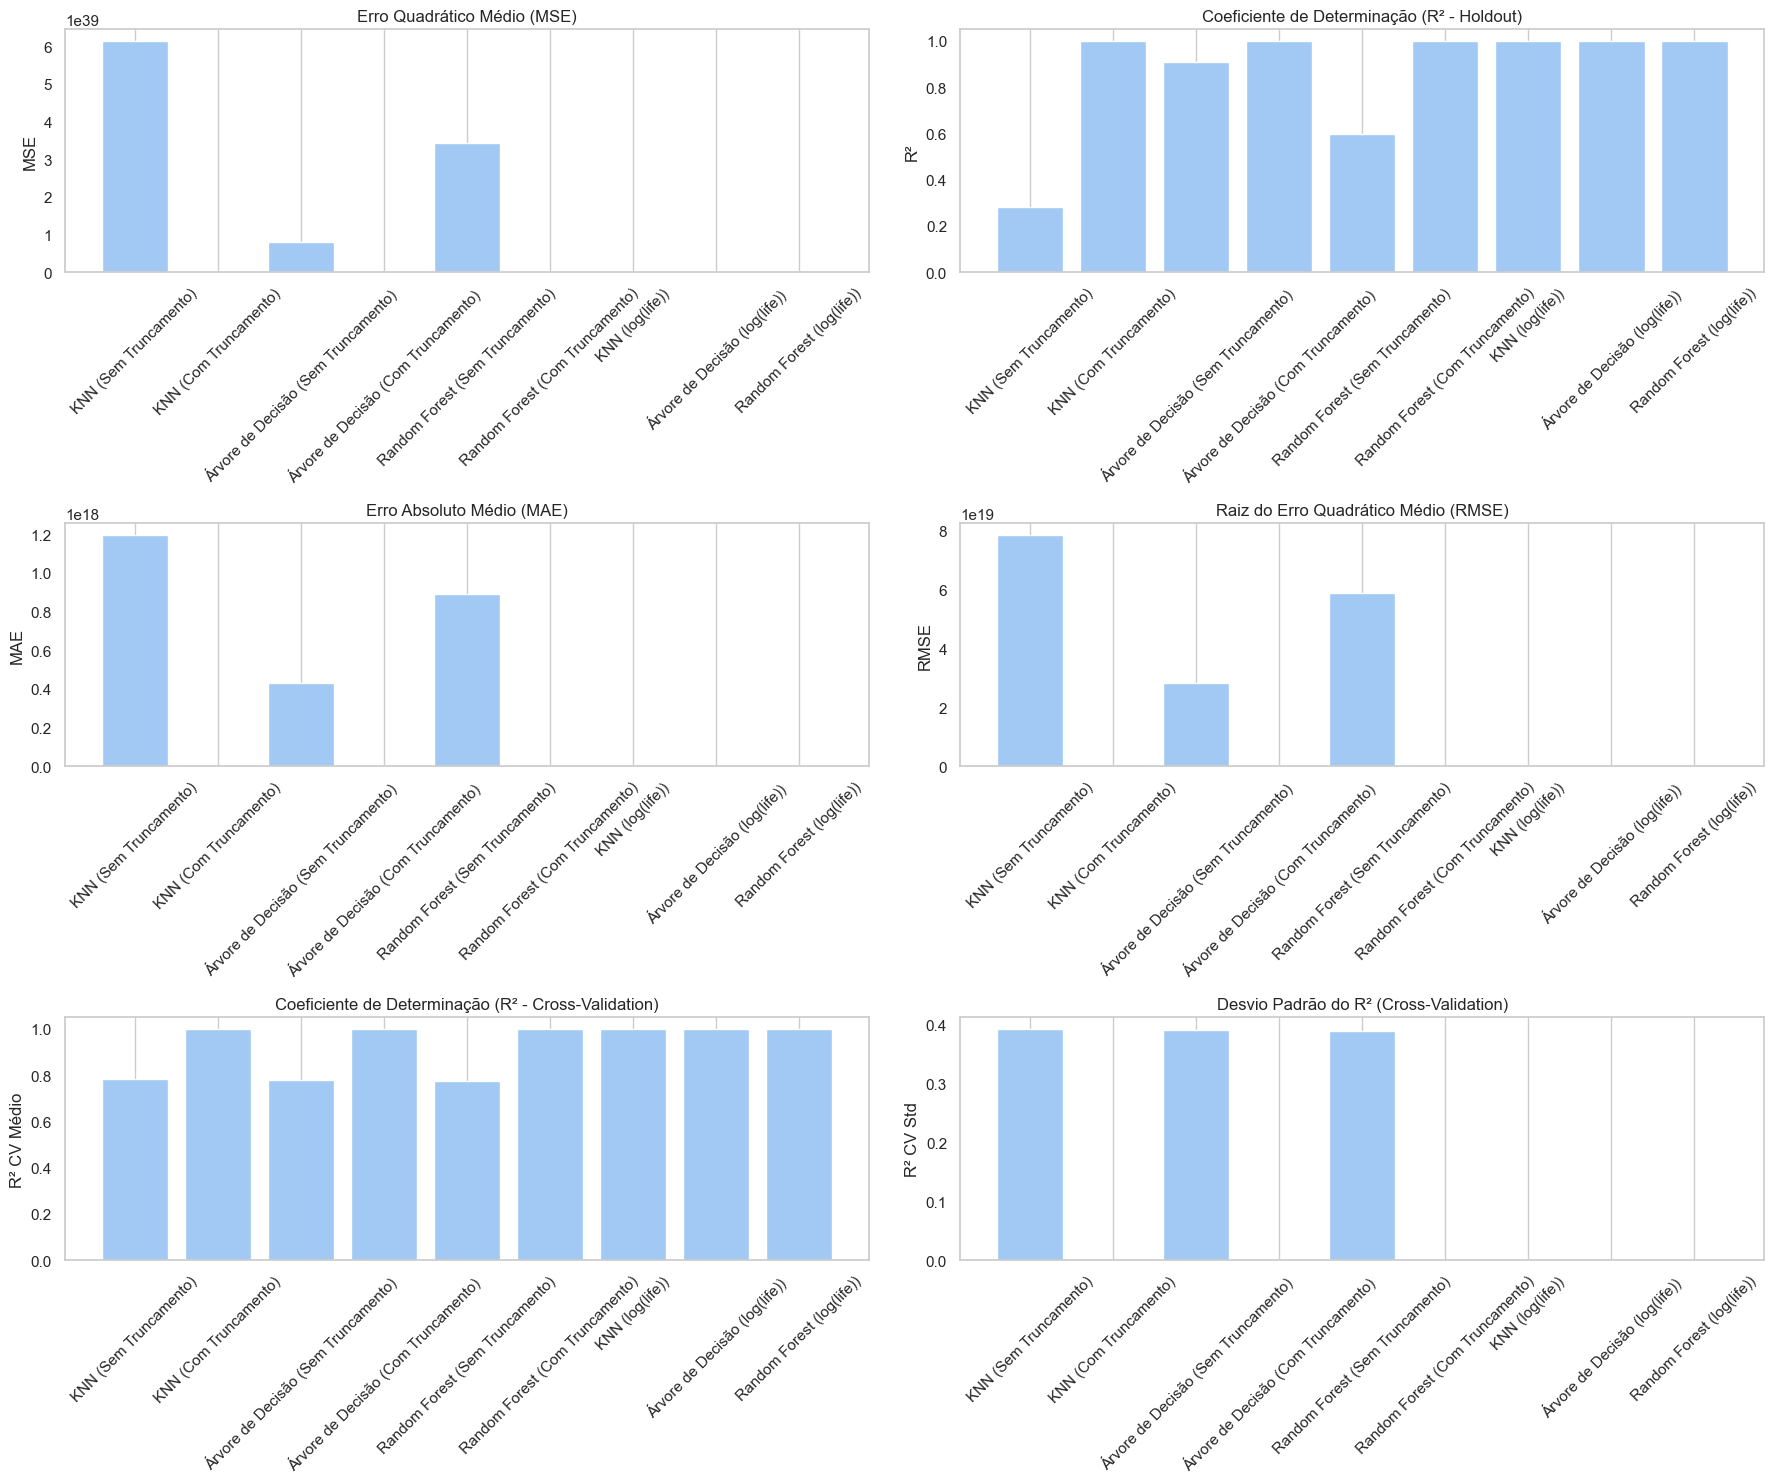

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()

metricas = [
    ("MSE", "Erro Quadrático Médio (MSE)"),
    ("R²", "Coeficiente de Determinação (R² - Holdout)"),
    ("MAE", "Erro Absoluto Médio (MAE)"),
    ("RMSE", "Raiz do Erro Quadrático Médio (RMSE)"),
    ("R² CV Médio", "Coeficiente de Determinação (R² - Cross-Validation)"),
    ("R² CV Std", "Desvio Padrão do R² (Cross-Validation)")
]

for i, (coluna, titulo) in enumerate(metricas):
    if coluna in results_df_completo.columns:
        eixo = axes[i]
        eixo.bar(
            results_df_completo["Modelo"] + " (" + results_df_completo["Truncado"] + ")",  # <- corrigido aqui
            results_df_completo[coluna]
        )
        eixo.set_title(titulo)
        eixo.set_ylabel(coluna)
        eixo.set_xticks(range(len(results_df_completo)))
        eixo.set_xticklabels(results_df_completo["Modelo"] + " (" + results_df_completo["Truncado"] + ")", rotation=45)
        eixo.grid(axis='y')

plt.tight_layout()
plt.show()


## Comparação: Modelos com e sem log(life)

In [56]:
# Criar versão com log(life)
df_log = df.copy()
df_log['life'] = np.log1p(df_log['life'])

In [59]:
results_cv_log = [
    avaliar_modelo_cv(df_log, KNeighborsRegressor(), "KNN", "log(life)"),
    avaliar_modelo_cv(df_log, DecisionTreeRegressor(random_state=42), "Árvore de Decisão", "log(life)"),
    avaliar_modelo_cv(df_log, SVR(), "SVM", "log(life)"),
    avaliar_modelo_cv(df_log, rf_model(), "Random Forest", "log(life)")
]

# Concatenar com os resultados anteriores
comparacao_final = pd.concat([results_df_completo, pd.DataFrame(results_cv_log)], ignore_index=True)
comparacao_final

,Modelo,Truncado,MAE,RMSE,MSE,R²,R² (Holdout),R² CV Médio,R² CV Std
0,KNN,Sem Truncamento,1.195928e+18,7.832335e+19,6.134547e+39,0.280999,0.280999,0.784713,3.919925e-01
1,KNN,Com Truncamento,1.503537e+02,6.989463e+02,4.885260e+05,0.999752,0.999752,0.999147,7.084995e-04
2,Árvore de Decisão,Sem Truncamento,4.310391e+17,2.812461e+19,7.909934e+38,0.907291,0.907291,0.780831,3.902547e-01
3,Árvore de Decisão,Com Truncamento,7.135820e+00,3.693495e+01,1.364191e+03,0.999999,0.999999,0.999999,2.005978e-07
4,Random Forest,Sem Truncamento,8.910647e+17,5.850413e+19,3.422733e+39,0.598838,0.598838,0.775716,3.892928e-01
5,Random Forest,Com Truncamento,5.452598e+00,2.719649e+01,7.396493e+02,1.000000,1.000000,1.000000,1.809041e-07
6,KNN,log(life),3.193444e-02,7.480871e-02,5.596342e-03,0.999889,0.999889,0.999542,3.016210e-04
7,Árvore de Decisão,log(life),2.946384e-03,1.559406e-02,2.431749e-04,0.999995,0.999995,0.999847,2.921610e-04
8,Random Forest,log(life),2.935334e-03,3.623720e-02,1.313134e-03,0.999974,0.999974,0.999867,2.605155e-04
9,KNN,log(life),NaN,NaN,NaN,NaN,NaN,0.999542,3.016210e-04


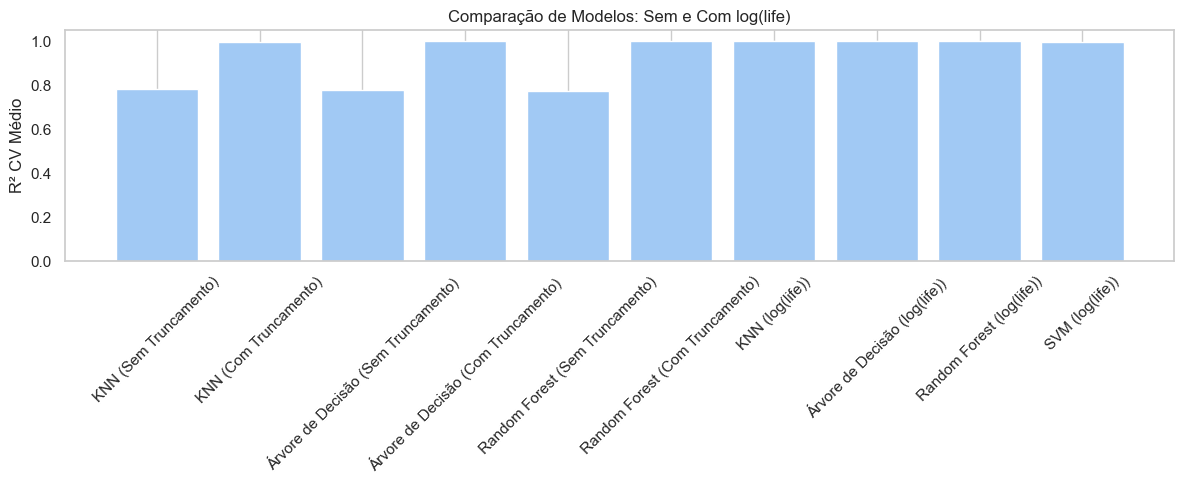

In [60]:
plt.figure(figsize=(12, 5))
plt.bar(comparacao_final["Modelo"] + " (" + comparacao_final["Truncado"] + ")", comparacao_final["R² CV Médio"])
plt.title("Comparação de Modelos: Sem e Com log(life)")
plt.ylabel("R² CV Médio")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [61]:
# Treinar modelo com log(life) e reverter para previsão real
from sklearn.tree import DecisionTreeRegressor

# Separar X e y com log
X_log = df_log.drop(columns='life')
y_log = df_log['life']  # já está em log1p

# Treinar modelo
modelo_log = DecisionTreeRegressor(random_state=42)
modelo_log.fit(X_log, y_log)

# Fazer previsão
previsao_log = modelo_log.predict(X_log)
previsao_revertida = np.expm1(previsao_log)  # reverter log1p para valor original

# Criar DataFrame com valores reais, previstos e erro
df_resultado = df.copy()
df_resultado['previsao_life'] = previsao_revertida
df_resultado['erro_percentual'] = abs(df_resultado['life'] - df_resultado['previsao_life']) / df_resultado['life']

# Criar coluna 'material' única para agrupar, caso não exista
if 'material' not in df_resultado.columns:
    df_resultado['material'] = 1
    df_resultado.loc[df_resultado['material_2'] == 1, 'material'] = 2
    df_resultado.loc[df_resultado['material_3'] == 1, 'material'] = 3

# Tabela resumo agrupada pelas principais colunas
tabela_resumo = df_resultado.groupby(['type', 'material']).agg({
    'life': 'mean',
    'previsao_life': 'mean',
    'erro_percentual': 'mean'
}).reset_index().rename(columns={
    'life': 'Media Vida Real',
    'previsao_life': 'Media Vida Prevista',
    'erro_percentual': 'Erro Percentual Médio'
})

display(tabela_resumo)

display(
    df_resultado[['type', 'material', 'life', 'previsao_life', 'erro_percentual']]
    .sort_values(by='erro_percentual', ascending=False)
)

,type,material,Media Vida Real,Media Vida Prevista,Erro Percentual Médio
0,0,1,2.201660e+10,2.201660e+10,3.416198e-11
1,0,2,1.179557e+03,1.179557e+03,5.019906e-11
2,1,3,1.843505e+18,1.843505e+18,2.543056e-11


,type,material,life,previsao_life,erro_percentual
8555,0,1,1.533752e+04,1.533752e+04,1.731864e-07
7223,0,2,1.533753e+04,1.533752e+04,1.731863e-07
19857,1,3,5.145444e+05,5.145445e+05,1.519694e-07
9621,0,1,5.145446e+05,5.145445e+05,1.519693e-07
14039,0,1,4.166056e+02,4.166056e+02,4.596224e-08
...,...,...,...,...,...
14608,0,1,1.092005e+01,1.092005e+01,0.000000e+00
5706,0,2,6.417005e+00,6.417005e+00,0.000000e+00
14605,0,1,1.547496e+01,1.547496e+01,0.000000e+00
14601,0,1,1.305613e+01,1.305613e+01,0.000000e+00
